In [25]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import matplotlib.pyplot as plt
from math import sin, cos, sqrt, atan2, radians

In [26]:
# import data
links = pd.read_csv("testlinks.csv")
nodes = pd.read_csv("testnodes.csv")
loads = pd.read_csv("testloads.csv")

In [27]:
links = links.groupby(['Node1', 'Node2']).sum()
print(links)

for i in links.index:
    print(i)

# parameters
loss = 0.05 # loss per mile
T = 42370 # TIME STEP JAN 1 2010

# create model
m = gp.Model("test")

# create cost function
cost = gp.LinExpr(0)

             Index  Limit
Node1 Node2              
1     2          2     10
2     3          1      5
      4          1      5
3     4          1      5
(1, 2)
(2, 3)
(2, 4)
(3, 4)


In [28]:
def dist(lat1, lat2, lon1, lon2):
    # approximate radius of earth in miles
    R = 3958.8

    lat1 = radians(52.2296756)
    lon1 = radians(21.0122287)
    lat2 = radians(52.406374)
    lon2 = radians(16.9251681)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c

In [29]:
# dictionary of junction (net power) equations at each node
j = {}

# create a linear expression at each node
for i in nodes.index:
    node = nodes['Node'][i]
    j[node] = gp.LinExpr(0)

# filter to generating nodes
gens = nodes[nodes['Limit'] > 0]

# dictionary of generator decision variables
g = {}

for i in gens.index:
    # add the decision variable
    node = gens['Node'][i]
    g[node] = m.addVar(lb = 0, ub = gens['Limit'][i])

    # add generation to net power at node
    j[node].add(g[node])

    # add cost to objective
    if gens['Type'][i] == 'Natural Gas':
        cost.add(g[node])

    if gens['Type'][i] == 'Coal':
        cost.add(g[node])

In [30]:
# FLOWS dictionary indexed by tuple (from, to) pairs
f = {}

# create flow variables
for i in links.index:
    # index nodes
    n1 = i[0]
    n2 = i[1]

    # create flow (decision) variable in each direction
    f[(n1, n2)] = m.addVar(lb = 0, ub = links['Limit'][i])
    f[(n2, n1)] = m.addVar(lb = 0, ub = links['Limit'][i])

    # FIND DISTANCE
    lat1 = nodes.loc[nodes['Node'] == n1 , 'Latitude'].values[0]
    lat2 = nodes.loc[nodes['Node'] == n2 , 'Latitude'].values[0]
    long1 = nodes.loc[nodes['Node'] == n1 , 'Longitude'].values[0]
    long2 = nodes.loc[nodes['Node'] == n2 , 'Longitude'].values[0]
    distance = dist(lat1, lat2, long1, long2)

    # add costs to objective
    cost.add(f[(n1, n2)], loss*distance)
    cost.add(f[(n2, n1)], loss*distance)

    # add to junctions (net power balance)
    j[n1].add(f[(n1,n2)], -1)
    j[n1].add(f[(n2,n1)], 1)
    j[n2].add(f[(n1,n2)], 1)
    j[n2].add(f[(n2,n1)], -1)

In [31]:
# LOADS
t_loads = loads.loc[loads['Time'] == T]
t_loads = t_loads.drop(columns = ['Time', 'Net'])

# add to junction sets
for col in t_loads:
    j[int(col)].add(-1*t_loads[col][0])


In [32]:
# Constraints
c = {}

for i in nodes.index:
    node = nodes['Node'][i]
    c[node] = m.addConstr(j[node] == 0)

# Objective
obj = m.setObjective(cost, GRB.MINIMIZE)

# Optimize
m.optimize()

# Print
print(m.getAttr('x', f))

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 4 rows, 10 columns and 18 nonzeros
Model fingerprint: 0x223e67ce
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 9e+00]
  Bounds range     [5e+00, 1e+01]
  RHS range        [5e+00, 7e+00]
Presolve removed 4 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.2711947e+02   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds
Optimal objective  1.271194721e+02
{(1, 2): 6.0, (2, 1): 0.0, (2, 3): 2.0, (3, 2): 0.0, (2, 4): 0.0, (4, 2): 1.0, (3, 4): 0.0, (4, 3): 5.0}


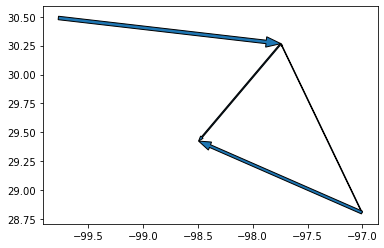

In [33]:
# Plot
ax = plt.axes()

for i in m.getAttr('x', f):
    n1 = i[0]
    n2 = i[1]
    
    lat1 = nodes.loc[nodes['Node'] == n1 , 'Latitude'].values[0]
    lat2 = nodes.loc[nodes['Node'] == n2 , 'Latitude'].values[0]
    long1 = nodes.loc[nodes['Node'] == n1 , 'Longitude'].values[0]
    long2 = nodes.loc[nodes['Node'] == n2 , 'Longitude'].values[0]
    
    if m.getAttr('x', f)[i] > 0:
        ax.arrow(long1, lat1, long2-long1, lat2-lat1, shape = 'full', length_includes_head = True, width = m.getAttr('x', f)[i]/200)
    